<a id='top'></a>

# Academic Mastery Study

**Improve academic evaluations by predicting whether a student will answer the next test question correctly.** Students taking advantage of practice exercises through various software applications seek an evaluation of their preparedness for formal academic assessments. They would like an an accurate evaluation of any gaps in knowledge and skills without sitting through exercises that repeatedly test established proficiencies and difficulties. The goal is to help test developers build an application that precisely evaluates competencies so that fewer demonstrations of proficiency can accurately determine mastery.

## THE DATA
---
Available from the [Grockit competition on Kaggle]( https://www.kaggle.com/c/WhatDoYouKnow/data).
```python
category_labels.csv
test.csv
training.csv
```
**Test** data does not include `answer_id` or `outcome` (from which correctness could be determined).

The test/training split is derived by finding *users who answered at least 6 questions*, taking **one** of their answers (uniformly random, *from their 6th question to their last*), and inserting it into the **test set**.
* Any *later answers by this user* are removed, 
* and any *earlier answers are included in the **training set***.  
* All answers *from users not in the test set are also used for the training set* (as they may be useful in estimating question parameters or baseline ability distributions).

The **test data** distribution is thus different from **training data** in ways that may be significant.  
* First, it does not include 'timeout' or 'skipped' outcomes: all test results are from the student actually answering the question.  
* Second, it is biased towards users with more questions in the training set and biased towards their later answers.  
* Third, it is one entry per user, so the distribution of various aspects of the data (such as correct/incorrect) is over users, not over all answered questions.

---

**`correct`: `0` or `1` [[TARGET]](#target) - indicates whether the student answered the question correctly.** Rename to **`outcome`** during 'data cleaning'.

**`user_id`**: [[**categorical**]](#user_id) - anonymized numeric identifier for the user answering the question.
       
**`question_id`**: [[**categorical**]](#question_id) - a numeric identifier for the question being answered.
     
**`question_type`**: [[**categorical**]](#question_type) - a numeric code representing the type of question; either `MultipleChoiceOneCorrect` (`0`) for multiple choice, or `SPR` (`1`) for free response questions.
   
**`group_name`**: [[**categorical**]](#group_name) - a numeric code representing the test group for this question `{'act':0, 'gmat':1, 'sat':2}`.

`group_name`

     track_name   
        
        subtrack_name
    
            tag_string

**`track_name`**: [[**categorical**]](#track_name) - the numeric code for the track within the test group for this question (mappings from category fields to numeric values are in `category_labels.csv`).

**`subtrack_name`**: [[**categorical**]](#subtrack_name) - the numeric code for the subtrack within the track for this question (mappings from category fields to numeric values are in category_labels.csv).

**`tag_string`**: [[**categorical**]](#tag_string) - a space-separated list of tag ids for this question (mappings from category fields to numeric values are in category_labels.csv).

**`round_started_at`**: [[**numeric**]](#round_started_at) [use this as reference date] - a UTC timestamp indicating when the question was available to the user.

**`answered_at`**: [[**numeric**]](#answered_at) [minutes from reference date] - a UTC timestamp indicating when the user answered the question (NULL if not answered).

**`deactivated_at`**: [[**numeric**]](#deactivated_at) [minutes from reference date] - a UTC timestamp indicating when the round finished, either because the user answered or the questioned timed-out.

**`game_type`**: [[**categorical**]](#game_type) - indicates the type of game/study session (mappings from category fields to numeric values are in category_labels.csv). More information on each of these is provided in the relevant section of this document.

**`num_players`**: [[**categorical**]](#num_players) - the number of players in the game at the time (multiple users can be viewing the same question simultaneously).

**`date_of_test`**: [numeric] [minutes from reference date] - the date the user entered as their expected test date (if entered). Eliminated during 'data cleaning'.

Columns added during the following process are described in the [document summary](#summary).

## DATA WRANGLING
---
Download the `grockit_all_data.zip` file from the [Grockit competition on Kaggle](https://www.kaggle.com/c/WhatDoYouKnow/data). Import and inspect raw training data. Isolate relevant variables and organize dataframe. Rectify missing, invalid or corrupted values.

### Import Packages & Training Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime

In [2]:
# Download grockit_all_data.zip from https://www.kaggle.com/c/WhatDoYouKnow/data,
# and save in the project's raw data directory.

# Read and save CSV file as dataframe:
df = pd.read_csv('../data/raw/training.csv') 

### Inspect Raw Data

In [3]:
# Inspect the current state of the dataset:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851475 entries, 0 to 4851474
Data columns (total 17 columns):
correct             int64
outcome             int64
user_id             int64
question_id         int64
question_type       int64
group_name          int64
track_name          int64
subtrack_name       int64
tag_string          object
round_started_at    object
answered_at         object
deactivated_at      object
answer_id           int64
game_type           int64
num_players         int64
date_of_test        object
question_set_id     int64
dtypes: int64(12), object(5)
memory usage: 629.2+ MB


The raw training dataset contains 17 variables (columns) and 4851475 observations (rows/entries).

In [4]:
# Get a pre-wrangling count of users:
print( ('Number of Users:'), len(df.user_id.value_counts()) ) 

Number of Users: 179106


In [5]:
# Get a pre-wrangling count of unique questions:
print(('Number of Unique Questions:'), (len( df.question_id.unique() )))

Number of Unique Questions: 6045


In [6]:
# Inspect the structure and first 5 observations of the raw dataset:
df.head()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
0,0,2,85818,5560,0,1,5,14,222 233 240 246,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,6540,7,1,NaN,1567
1,1,1,85818,4681,0,1,5,0,24 49,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,4742,7,1,NaN,1227
2,1,1,85818,1529,0,1,5,0,31 49,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,4309,7,1,NaN,1148
3,1,1,85818,2908,0,1,5,0,31 49,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,4408,7,1,NaN,1168
4,1,1,85818,1773,0,1,5,11,183 194 207,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,10822,7,1,NaN,2318


In [7]:
# Inspect the last 5 observations:
df.tail()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
4851470,1,1,58569,1633,0,1,4,9,47 82 118 161,2009-10-18 17:08:32,2009-10-18 17:09:06,2009-10-18 17:09:06,8811,7,1,2009-09-18,2017
4851471,0,4,58569,1775,0,1,4,1,4 52 135 262,2009-10-18 17:09:24,NaN,2009-10-18 17:10:03,25553,7,1,2009-09-18,2406
4851472,0,4,131842,1655,0,2,8,5,106 130 164,2010-04-19 23:13:02,NaN,2010-04-19 23:13:37,25553,7,5,NaN,368
4851473,0,4,131842,544,0,2,8,3,101 103 134 280,2010-04-19 23:13:48,NaN,2010-04-19 23:14:35,25553,7,5,NaN,470
4851474,0,4,52513,1272,0,2,7,13,239 245,2010-05-18 14:32:59,NaN,2010-05-18 14:35:15,25553,7,1,NaN,3676


Variables can be eliminated. Rows could be indexed and columns could be ordered more appropriately. Some of the date/time observations contain null values.

<a href='#top'>back to menu</a>

### Re-Organize Columns

Some columns, such as those not included in the test dataset, can be removed. Once the `outcome` column is eliminated, the `correct` column could be renamed to 'outcome', as it is more semantic. New columns, `round_ended_at` and `round_duration`, should be created with the appropriate manipulation or calculation. First, all relevant columns need to be converted to datetime or category.

In [8]:
# Create and save list of columns to convert to datetime:
time_columns = ['round_started_at', 'answered_at', 'deactivated_at']

# Loop through the time_columns list:
for column in time_columns:
    # Convert date strings to datetime objects; 
    # need to ‘coerce’ errors, since there are known NULL values:
    df[column] = pd.to_datetime(df[column], errors='coerce')

In [9]:
# Create and save list of columns to convert to categorical data type:
category_columns = ['group_name', 'track_name', 'subtrack_name', 'question_id', 
                    'question_type', 'game_type', 'num_players']

# Loop through the category_columns list:
for column in category_columns:
    # Convert column to category type:
    df[column] = df[column].astype('category')

In [10]:
# Drop selected columns and save results:
df = df.drop(['outcome', 'answer_id', 'question_set_id'], axis='columns')

# Change the name of 'correct' column to outcome:
df = df.rename(columns = {'correct':'outcome'})

In [11]:
# Fill round_ended_at with answered_at if not null, otherwise fill with deactivated_at:
df['round_ended_at'] = df['answered_at'].fillna(df['deactivated_at'])

# Inspect the null answered_at observations to confirm:
df[df.answered_at.isnull()].head()

,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,date_of_test,round_ended_at
10,0,85818,1338,0,1,5,11,193 207,2010-08-18 20:38:36,NaT,2010-08-18 20:39:24,7,1,NaN,2010-08-18 20:39:24
14,0,85818,2946,0,1,5,14,233 246,2010-08-20 14:27:06,NaT,2010-08-20 14:27:53,7,3,NaN,2010-08-20 14:27:53
17,0,85818,4884,0,1,5,14,221 226 227 233 246,2010-08-20 14:32:40,NaT,2010-08-20 14:34:40,7,3,NaN,2010-08-20 14:34:40
18,0,85818,5085,0,1,5,14,224 227 233 241 246,2010-08-20 14:35:02,NaT,2010-08-20 14:37:02,7,3,NaN,2010-08-20 14:37:02
21,0,85818,874,0,1,5,14,227 233 235 246,2010-08-20 14:39:54,NaT,2010-08-20 14:41:54,7,3,NaN,2010-08-20 14:41:54


In [12]:
# Calculate the round duration:
df['round_duration'] = df['round_ended_at'] - df['round_started_at']

# And inspect:
df.head()

,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,game_type,num_players,date_of_test,round_ended_at,round_duration
0,0,85818,5560,0,1,5,14,222 233 240 246,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,7,1,NaN,2010-08-18 20:18:18,00:01:05
1,1,85818,4681,0,1,5,0,24 49,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,7,1,NaN,2010-08-18 20:20:34,00:01:22
2,1,85818,1529,0,1,5,0,31 49,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,7,1,NaN,2010-08-18 20:21:56,00:01:14
3,1,85818,2908,0,1,5,0,31 49,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,7,1,NaN,2010-08-18 20:23:05,00:01:02
4,1,85818,1773,0,1,5,11,183 194 207,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,7,1,NaN,2010-08-18 20:26:08,00:02:57


In [13]:
# Reorder the columns and save:
column_labels = ['user_id', 'round_started_at', 'answered_at', 'deactivated_at', 'round_ended_at', 'round_duration', 
                 'outcome', 'group_name', 'track_name', 'subtrack_name', 'tag_string', 
                 'question_id', 'question_type', 'game_type', 'num_players', 'date_of_test']
df = df[column_labels]

# Reinspect the structure to confirm:
df.head(10)

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players,date_of_test
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,00:01:05,0,1,5,14,222 233 240 246,5560,0,7,1,NaN
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,00:01:22,1,1,5,0,24 49,4681,0,7,1,NaN
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,00:01:14,1,1,5,0,31 49,1529,0,7,1,NaN
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,00:01:02,1,1,5,0,31 49,2908,0,7,1,NaN
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,00:02:57,1,1,5,11,183 194 207,1773,0,7,1,NaN
5,85818,2010-08-18 20:26:17,2010-08-18 20:26:43,2010-08-18 20:26:43,2010-08-18 20:26:43,00:00:26,1,1,5,11,201 207,3170,0,7,2,NaN
6,85818,2010-08-18 20:27:29,2010-08-18 20:28:22,2010-08-18 20:28:22,2010-08-18 20:28:22,00:00:53,1,1,5,14,219 230 246,438,0,7,1,NaN
7,85818,2010-08-18 20:28:30,2010-08-18 20:32:19,2010-08-18 20:32:19,2010-08-18 20:32:19,00:03:49,1,1,5,11,189 207,1909,0,7,2,NaN
8,85818,2010-08-18 20:32:23,2010-08-18 20:32:45,2010-08-18 20:32:45,2010-08-18 20:32:45,00:00:22,1,1,5,11,189 207,111,0,7,1,NaN
9,85818,2010-08-18 20:32:49,2010-08-18 20:34:23,2010-08-18 20:36:06,2010-08-18 20:34:23,00:01:34,1,1,5,11,201 207,3125,0,7,3,NaN


In [14]:
# Inspect the restructured state of the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851475 entries, 0 to 4851474
Data columns (total 16 columns):
user_id             int64
round_started_at    datetime64[ns]
answered_at         datetime64[ns]
deactivated_at      datetime64[ns]
round_ended_at      datetime64[ns]
round_duration      timedelta64[ns]
outcome             int64
group_name          category
track_name          category
subtrack_name       category
tag_string          object
question_id         category
question_type       category
game_type           category
num_players         category
date_of_test        object
dtypes: category(7), datetime64[ns](4), int64(2), object(2), timedelta64[ns](1)
memory usage: 370.3+ MB


Since 3 columns were dropped, and 2 new columns created, there are now 16 data columns.

<a href='#top'>back to menu</a>

### Evaluate & Resolve Missing Data

In [15]:
# Get a null count for each column in the dataframe:
df.isnull().sum() 

user_id                   0
round_started_at         69
answered_at          556088
deactivated_at          100
round_ended_at           90
round_duration           90
outcome                   0
group_name                0
track_name                0
subtrack_name             0
tag_string                0
question_id               0
question_type             0
game_type                 0
num_players               0
date_of_test        3824208
dtype: int64

According to information provided with the datasets for this project, `date_of_test` is the date the user entered as their expected test date (**if entered**). Nearly 80% of these values are NULL, but that does not indicate how many users are associated with 'no date entered'.

The information also indicates that missing values from the `answered_at` column are NULL if not answered, so NULL in this case seems to be valuable information.

The NULL counts for `round_started_at` and `deactivated_at` are a bit of a mystery, so they are examined first.

In [16]:
# Create and apply the filter for NULL values in the round_started_at column, inspect:
df[df.round_started_at.isnull()]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players,date_of_test
502701,56022,NaT,NaT,NaT,NaT,NaT,0,2,8,5,79 106 172 280,5488,0,10,1,NaN
502702,56022,NaT,NaT,NaT,NaT,NaT,0,2,8,5,41 106 143,2315,0,10,1,NaN
560170,76463,NaT,NaT,NaT,NaT,NaT,1,2,8,5,79 106 172 280,5488,0,10,1,NaN
560171,76463,NaT,NaT,NaT,NaT,NaT,0,2,8,5,41 106 143,2315,0,10,1,NaN
560172,76463,NaT,NaT,NaT,NaT,NaT,1,2,6,7,5 131 138,225,0,10,1,NaN
560173,76463,NaT,NaT,NaT,NaT,NaT,1,2,6,7,1 5 108 131 269 279,5277,0,10,1,NaN
565302,13469,NaT,NaT,NaT,NaT,NaT,0,2,8,5,79 106 172 280,5488,0,10,1,NaN
565303,13469,NaT,NaT,NaT,NaT,NaT,0,2,8,5,41 106 143,2315,0,10,1,NaN
565304,13469,NaT,NaT,NaT,NaT,NaT,1,2,6,7,5 131 138,225,0,10,1,NaN
902333,75026,NaT,NaT,NaT,NaT,NaT,0,2,8,5,79 106 172 280,5488,0,10,1,NaN


There are 69 observations with no date/time info entered. The most noticeable pattern is that they all involve game_type 10 (StudyHallGame), described in the data documentation as "the newest type of game: in these, users are answering their own series of questions as though they were in a solo practice game, but there is a single "study hall" chat where people can ask for help on questions." There are only 2698 observations of this game type in the dataset.

Nonetheless, time data is an important factor in improving the efficiency of testing applications, so dropping the relatively few records with missing data seems appropriate.

In [17]:
# Drop all rows with NULL values for round_started_at, save the rest:
df = df.dropna(subset=['round_started_at']) 

In [18]:
# Create and apply the filter for NULL values in the deactivated_at column, inspect:
df[df.deactivated_at.isnull()]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players,date_of_test
68233,135094,2009-01-29 01:50:53,NaT,NaT,NaT,NaT,0,1,5,14,222 232 240 246,253,0,7,2,NaN
75692,122692,2009-06-25 17:35:54,2009-06-25 17:37:24,NaT,2009-06-25 17:37:24,00:01:30,0,2,6,15,15 137 204 261 279,4802,1,7,3,2009-11-24
125247,21595,2009-04-20 21:17:58,NaT,NaT,NaT,NaT,0,1,4,1,14 52 77 160 279,4494,0,7,5,NaN
131340,33450,2009-02-20 17:55:30,NaT,NaT,NaT,NaT,0,1,5,14,233 240 246,4632,0,7,1,NaN
394570,118125,2009-02-17 18:57:42,NaT,NaT,NaT,NaT,0,1,4,9,14 135 161,5276,0,7,1,NaN
501287,65358,2009-06-24 15:00:43,2009-06-24 15:01:58,NaT,2009-06-24 15:01:58,00:01:15,0,2,6,15,15 137 204 261 279,4802,1,7,5,NaN
573508,97518,2009-06-29 15:19:56,2009-06-29 15:21:57,NaT,2009-06-29 15:21:57,00:02:01,0,2,6,15,15 137 204 261 279,4802,1,7,5,2010-01-23
635613,122912,2008-10-30 19:34:32,NaT,NaT,NaT,NaT,0,1,5,14,233 238 241 246,1191,0,7,1,NaN
636051,51708,2008-12-24 20:20:17,NaT,NaT,NaT,NaT,0,1,5,11,193 207,4371,0,7,1,NaN
636853,57882,2008-10-21 02:43:55,NaT,NaT,NaT,NaT,0,1,4,9,14 113 161 250 279,5311,0,7,1,NaN


In [19]:
len(df[df.deactivated_at.isnull()])

31

Of the 31 NULL observations for `deactivated_at`, all were marked incorrect and all are for the game type 7.

Again, time is important information. Observations above with a date/time entered for answered_at provide the necessary information and should remain - the NULL values for deactivated_at in those rows can be filled or ignored. Since the observations with NULL values for both columns are not useful, they are dropped.

In [20]:
# Drop all rows with NULL values for both answered_at and deactivated_at, save the rest:
df = df.dropna(subset=['answered_at', 'deactivated_at'], how='all') 

# Filter and confirm the remaining NULL values for deactivated_at:
df[df.deactivated_at.isnull()]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players,date_of_test
75692,122692,2009-06-25 17:35:54,2009-06-25 17:37:24,NaT,2009-06-25 17:37:24,00:01:30,0,2,6,15,15 137 204 261 279,4802,1,7,3,2009-11-24
501287,65358,2009-06-24 15:00:43,2009-06-24 15:01:58,NaT,2009-06-24 15:01:58,00:01:15,0,2,6,15,15 137 204 261 279,4802,1,7,5,NaN
573508,97518,2009-06-29 15:19:56,2009-06-29 15:21:57,NaT,2009-06-29 15:21:57,00:02:01,0,2,6,15,15 137 204 261 279,4802,1,7,5,2010-01-23
2182467,62107,2009-06-24 15:00:43,2009-06-24 15:03:18,NaT,2009-06-24 15:03:18,00:02:35,0,2,6,15,15 137 204 261 279,4802,1,7,5,2009-12-05
2182473,62107,2009-06-24 15:14:55,2009-06-24 15:16:17,NaT,2009-06-24 15:16:17,00:01:22,0,2,6,15,15 137 204 261 279,4802,1,7,5,2009-12-05
2255176,135617,2009-04-29 16:44:09,2009-04-29 16:45:49,NaT,2009-04-29 16:45:49,00:01:40,0,2,6,15,5 138 261,2096,1,7,2,NaN
3013571,79815,2009-05-17 18:45:38,2009-05-17 18:46:40,NaT,2009-05-17 18:46:40,00:01:02,0,1,5,14,220 224 227 228 246,2734,0,7,3,NaN
3271948,35763,2009-04-21 06:26:50,2009-04-21 06:27:44,NaT,2009-04-21 06:27:44,00:00:54,0,1,4,9,14 55 77 135 161,4723,0,7,2,2009-07-17
3612310,107154,2009-04-15 22:33:50,2009-04-15 22:34:29,NaT,2009-04-15 22:34:29,00:00:39,0,2,6,15,78 137 147 261 279,2316,1,7,5,2009-06-06
4452269,48073,2009-06-24 15:00:43,2009-06-24 15:02:11,NaT,2009-06-24 15:02:11,00:01:28,0,2,6,15,15 137 204 261 279,4802,1,7,5,NaN


Those look like keepers. Now, a closer look at the test date column. 

In [21]:
# Get the number of users remaining after dropping observations:
len(df.user_id.unique())

179093

In [22]:
# Get the number of users who entered a value for date_of_test:
dot_df = df.set_index(['user_id'])
len(dot_df[dot_df.date_of_test.notnull()].groupby('user_id').sum())

22534

In [23]:
# Get the number of users who did not enter a value for date_of_test:
len(dot_df[dot_df.date_of_test.isnull()].groupby('user_id').sum())

156559

Only 22,534 of the 179,093 users provided an expected test date. Given that nearly 90% of the users did not provide a date, this column will not be analyzed.

In [24]:
# Drop selected columns and save results:
df = df.drop('date_of_test', axis='columns')

In [25]:
# Get a new null count for each column in the dataframe:
df.isnull().sum() 

user_id                  0
round_started_at         0
answered_at         555998
deactivated_at          10
round_ended_at           0
round_duration           0
outcome                  0
group_name               0
track_name               0
subtrack_name            0
tag_string               0
question_id              0
question_type            0
game_type                0
num_players              0
dtype: int64

This is useful and expected.

<a href='#top'>back to menu</a>

### Evaluate & Resolve Duplicate Data

Duplicates of user_id are expected and can be addressed by MultiIndexing with start times; however, there are a number of variables that in combination should be checked. First: `user_id`, `round_started_at`, `round_ended_at`, since it seems impossible for one user to have the same time stamp more than once.

In [26]:
# Set options to inspect ALL of the observations:
# pd.options.display.max_rows = 650
df[df.duplicated(['user_id', 'round_started_at', 'round_ended_at'], keep=False)]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players
84917,20440,2010-01-20 09:45:20,NaT,2010-01-20 09:45:21,2010-01-20 09:45:21,00:00:01,0,2,6,7,5 80 131 279,4526,0,7,1
84918,20440,2010-01-20 09:45:20,NaT,2010-01-20 09:45:21,2010-01-20 09:45:21,00:00:01,0,2,6,7,5 53 131 159 279,5141,0,7,4
134118,51203,2011-10-13 11:02:18,2011-10-13 04:08:18,2011-10-13 04:08:18,2011-10-13 04:08:18,-1 days +17:06:00,0,0,2,10,127 171 206,5261,0,6,1
134119,51203,2011-10-13 11:02:18,2011-10-13 04:08:18,2011-10-13 04:08:18,2011-10-13 04:08:18,-1 days +17:06:00,0,0,2,10,127 171 206,5261,0,6,1
134120,51203,2011-10-13 11:10:48,2011-10-13 04:16:48,2011-10-13 04:16:48,2011-10-13 04:16:48,-1 days +17:06:00,0,0,2,10,18 33 104 171,5738,0,6,1
134121,51203,2011-10-13 11:10:48,2011-10-13 04:16:48,2011-10-13 04:16:48,2011-10-13 04:16:48,-1 days +17:06:00,0,0,2,10,18 33 104 171,5738,0,6,1
134122,51203,2011-10-13 11:19:18,2011-10-13 04:25:18,2011-10-13 04:25:18,2011-10-13 04:25:18,-1 days +17:06:00,0,0,2,10,18 91 124 206,5349,0,6,1
134123,51203,2011-10-13 11:19:18,2011-10-13 04:25:18,2011-10-13 04:25:18,2011-10-13 04:25:18,-1 days +17:06:00,0,0,2,10,18 91 124 206,5349,0,6,1
134124,51203,2011-10-13 08:27:48,2011-10-13 04:33:48,2011-10-13 04:33:48,2011-10-13 04:33:48,-1 days +20:06:00,0,0,2,10,0 122 171 206,399,0,6,1
134125,51203,2011-10-13 08:27:48,2011-10-13 04:33:48,2011-10-13 04:33:48,2011-10-13 04:33:48,-1 days +20:06:00,0,0,2,10,0 122 171 206,399,0,6,1


A number of the observations above involve the same start and end time. This warrants a closer look. Another anomaly involves a number of users with `round_started_at` times later than `round_ended_at`, but the pattern that emerged from inspecting such is that all of the observations involve 10-13-2011. 

In [27]:
# Reset to default the number of rows returned:
# pd.reset_option('max_rows')

# Get all observations for 2011-10-13 by round_started_at:
df[(df['round_started_at'] > '2011-10-13 00:00:00') & (df['round_started_at'] < '2011-10-13 23:59:59')]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players
2940,131493,2011-10-13 18:50:41,NaT,2011-10-13 18:51:54,2011-10-13 18:51:54,00:01:13,0,0,3,12,22 43 45 50 123 129 243,5628,0,4,6
9301,133464,2011-10-13 13:30:03,2011-10-13 13:31:32,2011-10-13 13:32:33,2011-10-13 13:31:32,00:01:29,1,1,4,9,4 77 161 251,4952,0,7,2
9302,133464,2011-10-13 13:32:56,2011-10-13 13:34:38,2011-10-13 13:34:49,2011-10-13 13:34:38,00:01:42,0,1,4,9,14 74 135 161,1856,0,7,2
9303,133464,2011-10-13 13:35:32,2011-10-13 13:36:34,2011-10-13 13:38:02,2011-10-13 13:36:34,00:01:02,0,1,4,9,14 68 71 77 161,4103,0,7,2
9304,133464,2011-10-13 13:40:32,NaT,2011-10-13 13:41:35,2011-10-13 13:41:35,00:01:03,0,1,4,9,4 77 161 251,699,0,7,3
17460,164667,2011-10-13 21:31:02,2011-10-13 21:31:12,2011-10-13 21:31:13,2011-10-13 21:31:12,00:00:10,1,0,1,6,112 125 158,3943,0,7,1
17461,164667,2011-10-13 21:31:14,2011-10-13 21:31:23,2011-10-13 21:31:23,2011-10-13 21:31:23,00:00:09,1,0,1,6,64 125 204,4351,0,7,1
17462,164667,2011-10-13 21:31:24,2011-10-13 21:31:32,2011-10-13 21:31:33,2011-10-13 21:31:32,00:00:08,1,0,1,6,21 64 125 254,1959,0,7,1
17463,164667,2011-10-13 21:31:33,2011-10-13 21:31:38,2011-10-13 21:31:39,2011-10-13 21:31:38,00:00:05,1,0,1,6,75 125 155,1181,0,7,1
17464,164667,2011-10-13 21:31:40,2011-10-13 21:31:43,2011-10-13 21:31:44,2011-10-13 21:31:43,00:00:03,1,0,1,6,64 125 135,2196,0,7,1


A quick inspection of the rows above reveals that the noticeable weirdness before is not true for all of the 10-13-2011 observations, so a revised approach:

In [28]:
# Get all observations where round_ended_at times are before round_started_at time:
df[df['round_started_at'] > df['round_ended_at']]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players
134118,51203,2011-10-13 11:02:18,2011-10-13 04:08:18,2011-10-13 04:08:18,2011-10-13 04:08:18,-1 days +17:06:00,0,0,2,10,127 171 206,5261,0,6,1
134119,51203,2011-10-13 11:02:18,2011-10-13 04:08:18,2011-10-13 04:08:18,2011-10-13 04:08:18,-1 days +17:06:00,0,0,2,10,127 171 206,5261,0,6,1
134120,51203,2011-10-13 11:10:48,2011-10-13 04:16:48,2011-10-13 04:16:48,2011-10-13 04:16:48,-1 days +17:06:00,0,0,2,10,18 33 104 171,5738,0,6,1
134121,51203,2011-10-13 11:10:48,2011-10-13 04:16:48,2011-10-13 04:16:48,2011-10-13 04:16:48,-1 days +17:06:00,0,0,2,10,18 33 104 171,5738,0,6,1
134122,51203,2011-10-13 11:19:18,2011-10-13 04:25:18,2011-10-13 04:25:18,2011-10-13 04:25:18,-1 days +17:06:00,0,0,2,10,18 91 124 206,5349,0,6,1
134123,51203,2011-10-13 11:19:18,2011-10-13 04:25:18,2011-10-13 04:25:18,2011-10-13 04:25:18,-1 days +17:06:00,0,0,2,10,18 91 124 206,5349,0,6,1
134124,51203,2011-10-13 08:27:48,2011-10-13 04:33:48,2011-10-13 04:33:48,2011-10-13 04:33:48,-1 days +20:06:00,0,0,2,10,0 122 171 206,399,0,6,1
134125,51203,2011-10-13 08:27:48,2011-10-13 04:33:48,2011-10-13 04:33:48,2011-10-13 04:33:48,-1 days +20:06:00,0,0,2,10,0 122 171 206,399,0,6,1
134126,51203,2011-10-13 11:36:18,2011-10-13 04:42:18,2011-10-13 04:42:18,2011-10-13 04:42:18,-1 days +17:06:00,0,0,2,10,32 132 206,4276,0,6,1
134127,51203,2011-10-13 11:36:18,2011-10-13 04:42:18,2011-10-13 04:42:18,2011-10-13 04:42:18,-1 days +17:06:00,0,0,2,10,32 132 206,4276,0,6,1


In [29]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df['round_started_at'] > df['round_ended_at']].index)

In [30]:
# Get all observations where round_started_at times are the same as round_ended_at time:
df[df['round_started_at'] == df['round_ended_at']]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players
3727,44733,2011-05-30 14:40:37,NaT,2011-05-30 14:40:37,2011-05-30 14:40:37,0 days,0,1,5,11,189 207,1190,0,5,1
7564,156508,2010-03-02 17:41:08,NaT,2010-03-02 17:41:08,2010-03-02 17:41:08,0 days,0,0,1,6,82 125 128 167 168 169 214 279,200,0,7,1
9885,43762,2010-01-11 02:55:23,NaT,2010-01-11 02:55:23,2010-01-11 02:55:23,0 days,0,0,1,6,21 64 125 268,604,0,7,2
10914,3769,2011-03-30 22:59:10,2011-03-30 22:59:10,2011-03-30 22:59:12,2011-03-30 22:59:10,0 days,0,2,6,7,5 83 119 131 169,4905,0,7,1
11124,94864,2010-02-24 13:15:55,NaT,2010-02-24 13:15:55,2010-02-24 13:15:55,0 days,0,2,6,7,19 53 131 159 279,4556,0,5,3
16563,18373,2010-06-22 18:11:35,NaT,2010-06-22 18:11:35,2010-06-22 18:11:35,0 days,0,2,6,7,5 88 131 167 176,2528,0,4,1
16955,36060,2010-04-21 17:04:13,2010-04-21 17:04:13,2010-04-21 17:04:13,2010-04-21 17:04:13,0 days,0,2,7,8,145 179 190,4529,0,4,1
17506,23294,2011-09-09 17:59:21,NaT,2011-09-09 17:59:21,2011-09-09 17:59:21,0 days,0,1,5,11,201 207,5957,0,5,1
19689,110444,2011-06-17 17:21:40,2011-06-17 17:21:40,2011-06-17 17:21:41,2011-06-17 17:21:40,0 days,0,0,2,10,0 100 171 206,294,0,7,1
21168,18666,2009-12-24 22:39:58,NaT,2009-12-24 22:39:58,2009-12-24 22:39:58,0 days,0,2,6,7,5 80 131 256 269 279,2571,0,7,1


Nothing stands out to indicate another pattern or cause, but it seems illogical that a user would have time to read a question within one second. These will be dropped.

In [31]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df['round_started_at'] == df['round_ended_at']].index)

In [32]:
# Drop duplicates of the remaining observations:
df = df.drop_duplicates(['user_id', 'round_started_at', 'round_ended_at'])

<a href='#top'>back to menu</a>

### Resolve a Known NULL Issue

Noticed in game_type notes below and need to address this: "NULL: 6 - values represent a data collection failure." So, NULL counts are not showing up for the game_type column because they are represented by 6.

In [33]:
# Get all observations where game_type value is 6:
df[df.game_type == 6]

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players
337399,114672,2011-10-13 01:26:57,2011-10-13 06:28:19,2011-10-13 06:28:19,2011-10-13 06:28:19,05:01:22,1,2,6,7,76 131 137 157,5941,0,6,1
347457,138292,2011-10-13 08:09:09,2011-10-13 13:43:09,2011-10-13 13:43:09,2011-10-13 13:43:09,05:34:00,0,2,7,8,145 177 186 190,5789,0,6,1
347463,138292,2011-10-13 06:34:28,2011-10-13 14:35:00,2011-10-13 14:35:00,2011-10-13 14:35:00,08:00:32,1,2,8,5,41 106 275,673,0,6,1
2326300,75293,2011-10-13 12:33:47,2011-10-13 18:04:22,2011-10-13 18:04:22,2011-10-13 18:04:22,05:30:35,1,0,1,6,125 242 272,4317,0,6,1
2448522,127290,2011-10-12 20:14:06,2011-10-13 02:15:43,2011-10-13 02:15:43,2011-10-13 02:15:43,06:01:37,1,0,1,6,21 125 155,5401,0,6,1
2448526,127290,2011-10-12 20:16:35,2011-10-13 02:17:29,2011-10-13 02:17:29,2011-10-13 02:17:29,06:00:54,1,0,1,6,82 125 128 168,74,0,6,1
2492257,144926,2011-10-13 11:51:55,2011-10-13 15:52:46,2011-10-13 15:52:46,2011-10-13 15:52:46,04:00:51,1,0,1,6,46 54 125 279,5599,0,6,1
2492261,144926,2011-10-13 10:23:37,2011-10-13 15:54:29,2011-10-13 15:54:29,2011-10-13 15:54:29,05:30:52,1,0,1,6,54 125 135 155 204 279,2160,0,6,1
4042799,71119,2011-10-13 09:59:09,2011-10-13 15:32:09,2011-10-13 15:32:09,2011-10-13 15:32:09,05:33:00,0,0,1,6,21 125 155,5401,0,6,1
4042815,71119,2011-10-13 10:47:10,2011-10-13 16:20:10,2011-10-13 16:20:10,2011-10-13 16:20:10,05:33:00,0,0,1,6,64 125 279,1094,0,6,1


The 15 observations above are known to represent a data collection failure for game_type. Also noticeable is that they all belong to the seemingly problematic date that stood out before: 10-13-2011, and the round duration for each observation is greater than 5 hours. These are dropped.

In [34]:
# Apply the filter to the dataframe, drop the corresponding rows, save the rest:
df = df.drop(df[df.game_type == 6].index)

### One More Tweak Before Further Exploration

In [35]:
# Split the space delimited tag_string into a list of tag_ids
df['tag_string'] = df.tag_string.str.split(' ')

# Change the name of 'tag_string' column to tag_ids:
df = df.rename(columns = {'tag_string':'tag_ids'})

# Confirm the changes:
df.tag_ids.head()

0    [222, 233, 240, 246]
1                [24, 49]
2                [31, 49]
3                [31, 49]
4         [183, 194, 207]
Name: tag_ids, dtype: object

In [36]:
# Re-inspect the state and structure of the dataframe:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4846730 entries, 0 to 4851474
Data columns (total 15 columns):
user_id             int64
round_started_at    datetime64[ns]
answered_at         datetime64[ns]
deactivated_at      datetime64[ns]
round_ended_at      datetime64[ns]
round_duration      timedelta64[ns]
outcome             int64
group_name          category
track_name          category
subtrack_name       category
tag_ids             object
question_id         category
question_type       category
game_type           category
num_players         category
dtypes: category(7), datetime64[ns](4), int64(2), object(1), timedelta64[ns](1)
memory usage: 370.0+ MB
None


,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_ids,question_id,question_type,game_type,num_players
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,00:01:05,0,1,5,14,"[222, 233, 240, 246]",5560,0,7,1
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,00:01:22,1,1,5,0,"[24, 49]",4681,0,7,1
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,00:01:14,1,1,5,0,"[31, 49]",1529,0,7,1
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,00:01:02,1,1,5,0,"[31, 49]",2908,0,7,1
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,00:02:57,1,1,5,11,"[183, 194, 207]",1773,0,7,1


4,745 of the original 4,851,475 observations were dropped for unresolvable NULL values or duplicates, leaving 4,846,730 observations to explore further. Columns are of the appropriate data type. Since the last inspection of info, the `date_of_test` column was dropped, leaving 15 columns currently in the dataframe.

<a id='round_started_at' href='#top'>back to menu</a>

## TIME DATA EXPLORATION
---

#### round_started_at
---

[use this as reference datetime]

In [37]:
df.round_started_at.describe() 

count                 4846730
unique                4192338
top       2010-09-29 18:26:17
freq                       23
first     2008-08-26 18:34:30
last      2011-11-16 08:13:07
Name: round_started_at, dtype: object

#### answered_at
---

[minutes from reference datetime]

In [38]:
df.answered_at.describe()

count                 4293923
unique                4144358
top       2011-03-02 13:11:22
freq                        6
first     2008-08-26 18:39:02
last      2011-11-16 08:13:34
Name: answered_at, dtype: object

#### deactivated_at
---

[minutes from reference datetime]

In [39]:
df.deactivated_at.describe()

count                 4846720
unique                4205673
top       2010-09-29 18:27:26
freq                       22
first     2008-08-26 18:34:57
last      2011-11-16 08:13:35
Name: deactivated_at, dtype: object

#### round_ended_at
---

[minutes from reference datetime]

In [40]:
df.round_ended_at.describe()

count                 4846730
unique                4645504
top       2010-09-29 18:27:26
freq                       22
first     2008-08-26 18:34:57
last      2011-11-16 08:13:34
Name: round_ended_at, dtype: object

None of the time variables above stand out as questionable. The difference between count and unique can be explained by the fact that for some games multiple users can participate in the question rounds together. First and last for all variables look normal, but that only accounts for 2 observations. Round duration is the time feature of interest for this study, so a closer look at such is next.

#### round_duration
---

[minutes from reference datetime]

In [41]:
df.round_duration.describe()

count                   4846730
mean     0 days 00:01:07.679064
std      0 days 00:19:49.418308
min             0 days 00:00:01
25%             0 days 00:00:26
50%             0 days 00:00:51
75%             0 days 00:01:31
max            28 days 03:21:38
Name: round_duration, dtype: object

The only statistic that seems odd is the max value. That a user took 28 days to answer a question warrants further exploration.

In [42]:
(df.round_duration > '1days').sum()

5

In [43]:
(df.round_duration > '1hours').sum()

436

In [44]:
(df.round_duration > '10minutes').sum()

4381

In [45]:
df = df.drop(df[df.round_duration > '10minutes'].index)

In [46]:
df.round_duration.describe()

count                   4842349
mean     0 days 00:01:05.264447
std      0 days 00:00:54.350775
min             0 days 00:00:01
25%             0 days 00:00:26
50%             0 days 00:00:51
75%             0 days 00:01:31
max             0 days 00:10:00
Name: round_duration, dtype: object

## CATEGORICAL DATA EXPLORATION
---
Inspect variables and analayze outliers. Keep these general questions in mind:

* How many are unique?

* How many questions per unique value?

* What are the statistics related to outcome?

In trying to predict whether a user will answer the next test question correctly, this study focuses on the performance of both users and specific questions.

__For Clarification__:
* question = observation (row)
* unique question = `question_id`
* user = `user_id`

<a id='target' href='#top'>back to menu</a>

### Target (`outcome`) Statistics

In [47]:
df.outcome.describe()

count    4.842349e+06
mean     5.480361e-01
std      4.976872e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: outcome, dtype: float64

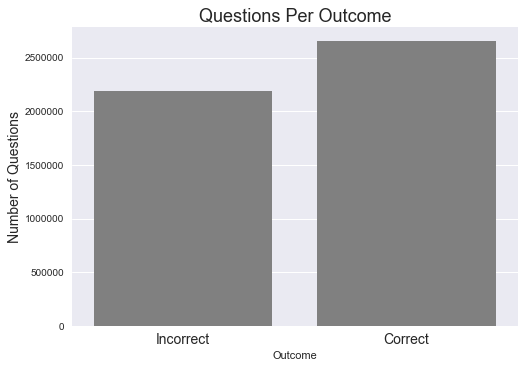

In [48]:
# Create bar plot for outcome distribution:
sns.countplot(data=df, x='outcome', color='grey');

# Create bar labels:
plt.xticks(np.arange(2), ('Incorrect', 'Correct'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('Outcome')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions Per Outcome', fontsize=18)

# Display the plot:
plt.show()

### Users and Unique Questions

<a id='user_id' href='#top'>back to menu</a>

#### `user_id`
---

1. How many users?
2. How many questions per user?
3. What are user statistics related to outcome?

Also:
* Best/worst performing users?
* Time spent answering questions?

In [49]:
# Count the number of unique user_id values:
print( ('Number of Users:'), len(df.user_id.value_counts()) ) 

Number of Users: 178982


In [50]:
# Count and save the number of questions per user:
questions_per_user = df.user_id.value_counts()
print(questions_per_user.head(2))

# Convert to a dataframe, reset the index for future plotting and drop resulting extra column:
questions_per_user = questions_per_user.to_frame('question_count').reset_index().drop('index', axis='columns')

# Print the first 5 observations and inspect:
questions_per_user.head()

133472    10024
139564     7172
Name: user_id, dtype: int64


,question_count
0,10024
1,7172
2,7138
3,7019
4,6758


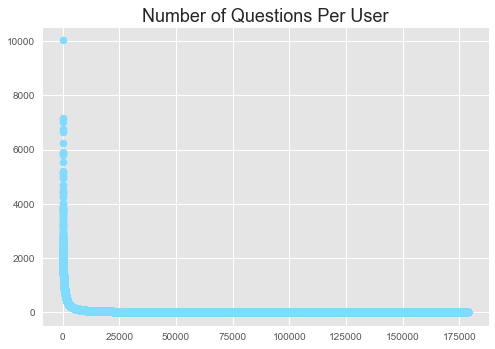

In [51]:
# Set the plot style:
plt.style.use('ggplot')

# Create questions_per_user scatter plot:
plt.scatter(questions_per_user.index, questions_per_user.question_count, color='#7fdbff')

# Create the title of the plot:
plt.title('Number of Questions Per User', fontsize=18)

# Set each axis scale and limits:
# plt.yscale('log')
# plt.xlim(0,2000)
# plt.xlim(0,1000)

# Display the plot:
plt.show()

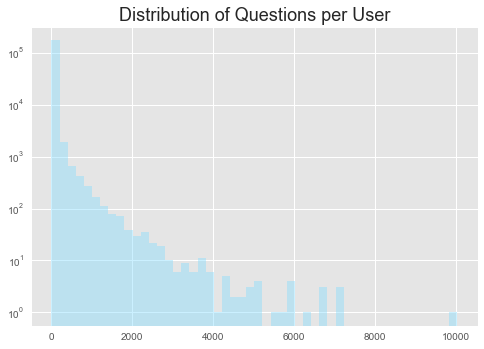

In [52]:
# Create a histogram of questions_per_user:
sns.distplot(questions_per_user, kde=False, color='#7fdbff')

# Set each axis scale and limits:
plt.yscale('log')
# plt.xlim(0,8000)

# Create a title:
plt.title('Distribution of Questions per User', fontsize=18)

# Display the plot:
plt.show() 

In [53]:
# Set up some variables to inspect ratios and distributions of correct, incorrect:

# Save the total number of entries per user in the outcome column:
question_count = df.groupby('user_id')['outcome'].count()

# Save the total number of correct entries per user in the 'outcome' column;
# values are 0 (incorrect) and 1 (correct), so a sum of values in the column will do:
correct_answer_count = df.groupby('user_id')['outcome'].sum()

# Save the total number of incorrect entries per user by subracting correct from total:
incorrect_answer_count = question_count.subtract(correct_answer_count)

# Save the ratio of correct answers per user, dividing by total:
ratio = correct_answer_count/question_count

# Build and save the dictionary and dataframe to look at user scores:
user_score = {
    'num_questions': question_count,
    'num_correct': correct_answer_count,
    'num_incorrect': incorrect_answer_count,
    'correct_ratio': ratio
}
df_user_score = pd.DataFrame(user_score)

# Rearrange the column order:
df_user_score = df_user_score[['num_correct', 'num_incorrect', 
                               'num_questions', 'correct_ratio']]

# Inspect the structure and values in the first 5 rows of the user score dataframe:
df_user_score.head() 

,num_correct,num_incorrect,num_questions,correct_ratio
user_id,,,,
0,5,2,7,0.714286
1,6,8,14,0.428571
2,2,6,8,0.250000
3,3,4,7,0.428571
4,7,4,11,0.636364


In [54]:
df_user_score.describe() 

,num_correct,num_incorrect,num_questions,correct_ratio
count,178982.000000,178982.000000,178982.000000,178982.000000
mean,14.827089,12.227861,27.054950,0.354254
std,92.471662,59.550473,145.912805,0.307013
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000
50%,2.000000,3.000000,6.000000,0.363636
75%,6.000000,7.000000,13.000000,0.600000
max,8018.000000,5328.000000,10024.000000,1.000000


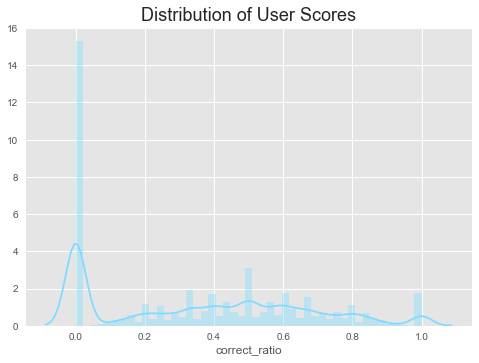

In [55]:
# Create a distribution plot of user scores (correct ratio)
sns.distplot(df_user_score.correct_ratio, color='#7fdbff')

# Create a title:
plt.title('Distribution of User Scores', fontsize=18)

# Display the plot:
plt.show()  

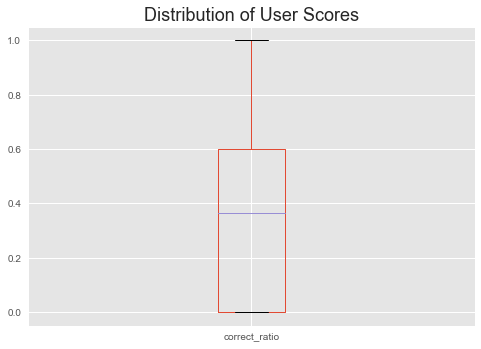

In [56]:
# Create a box plot of the user scores:
df_user_score.boxplot(column='correct_ratio')

# Create a title:
plt.title('Distribution of User Scores', fontsize=18)

# Display the plot:
plt.show() 

In [57]:
# Inspect distribution of score percentiles:
df_user_score['correct_ratio'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0    0.000000
0.1    0.000000
0.2    0.000000
0.3    0.000000
0.4    0.250000
0.5    0.363636
0.6    0.461538
0.7    0.545455
0.8    0.636364
0.9    0.782609
1.0    1.000000
Name: correct_ratio, dtype: float64

In [58]:
# Number of users with question count == 1
num_questions_filter = df_user_score.num_questions == 1
print( ('Number of users with only one question:'), len(df_user_score[num_questions_filter]) ) 

Number of users with only one question: 35868


In [59]:
# Number of users with score == 0
correct_ratio_filter = df_user_score.correct_ratio == 0
print( ('Number of users with no correct answers:'), len(df_user_score[correct_ratio_filter]) ) 

Number of users with no correct answers: 58269


In [60]:
# Number of users with 1 question & score of 0:
count_and_score_filter = num_questions_filter & correct_ratio_filter
print(('Number of users with 1 question that is incorrect:'), 
     (len(df_user_score[count_and_score_filter])))

Number of users with 1 question that is incorrect: 34308


In [61]:
# Top scores for users attempting more than 30 questions - 

# Filter by num_questions, sort the results by correct_ratio, save:
user_rank = df_user_score[df_user_score.num_questions > 30].sort_values(by='correct_ratio', 
                                                                        ascending=False)
# Inspect the top 10:
user_rank.head(10)

,num_correct,num_incorrect,num_questions,correct_ratio
user_id,,,,
98572,41,0,41,1.000000
7844,103,0,103,1.000000
94839,56,0,56,1.000000
17794,33,0,33,1.000000
150633,32,0,32,1.000000
26406,138,2,140,0.985714
155656,68,1,69,0.985507
93001,46,1,47,0.978723
102646,40,1,41,0.975610


In [62]:
# Worst scores for users attempting more than 30 questions - 
# Filter by num_questions, sort the results by correct_ratio, inspect the bottom 10:
df_user_score[df_user_score.num_questions > 30].sort_values(by='correct_ratio').head(10)

,num_correct,num_incorrect,num_questions,correct_ratio
user_id,,,,
28859,0,32,32,0.000000
106065,0,62,62,0.000000
77138,0,52,52,0.000000
100283,0,233,233,0.000000
158712,0,34,34,0.000000
56124,0,37,37,0.000000
154426,0,37,37,0.000000
143737,0,69,69,0.000000
122241,0,59,59,0.000000


In [63]:
# Get statistics on round_duration by user_id:


<a id='question_id' href='#top'>back to menu</a>

#### question_id
---

1. How many unique questions?
2. How many questions per question_id?
3. What are the statistics related to outcome?

Also:
* Best/worst performing questions?
* Which have the best/worst times?

In [64]:
# Print the number of unique question_id values:
print(('Number of Unique Questions:'), (len( df.question_id.unique() )))

Number of Unique Questions: 6045


In [65]:
# Count and save the number of questions per question_id:
questions_per_questionid = df.question_id.value_counts()
questions_per_questionid.head(10)

4059    14406
1272    13583
4952    10444
1928    10351
4444    10272
1883    10169
2179    10149
5252     9353
5706     9258
1856     9086
Name: question_id, dtype: int64

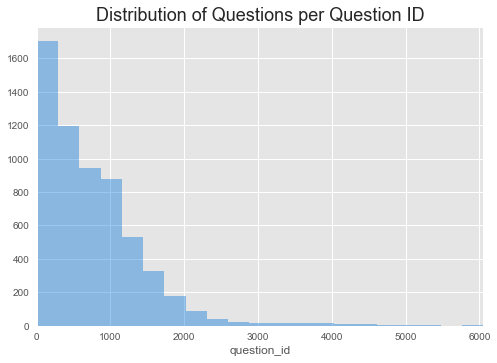

In [66]:
# Create a histogram of questions_per_questionid:
sns.distplot(questions_per_questionid, kde=False, color='#0074d9')

# Set each axis scale and limits:
# plt.yscale('log')
plt.xlim(0,6050)

# Create a title:
plt.title('Distribution of Questions per Question ID', fontsize=18)

# Display the plot:
plt.show() 

### Question Features

<a id='group_name' href='#top'>back to menu</a>

#### group_name
---

1. How many groups?
2. How many questions per group?
3. What are the statistics related to outcome?

In [67]:
# Print the number of unique group_name values:
print(('Number of Groups:'), (len( df.group_name.unique() )))

Number of Groups: 3


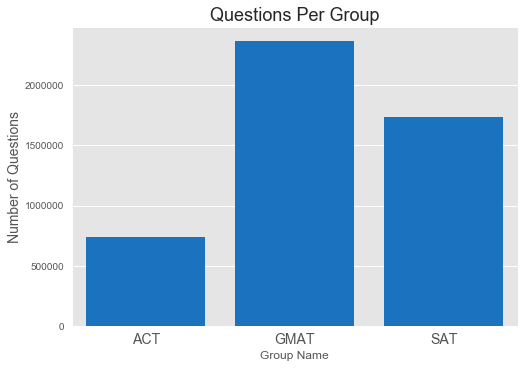

In [68]:
# Create bar plot for group_name distribution:
sns.countplot(data=df, x="group_name", color='#0074d9');

# Create bar labels:
# {'act':0, 'gmat':1, 'sat':2}
plt.xticks(np.arange(3), ('ACT', 'GMAT', 'SAT'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('Group Name')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions Per Group', fontsize=18)

# Display the plot:
plt.show()

<a id='track_name' href='#top'>back to menu</a>

#### track_name
---

1. How many tracks?
2. How many questions per track?
3. What are the statistics related to outcome?

In [69]:
# Print the number of unique track_name values:
print(('Number of Tracks:'), (len( df.track_name.unique() )))

Number of Tracks: 9


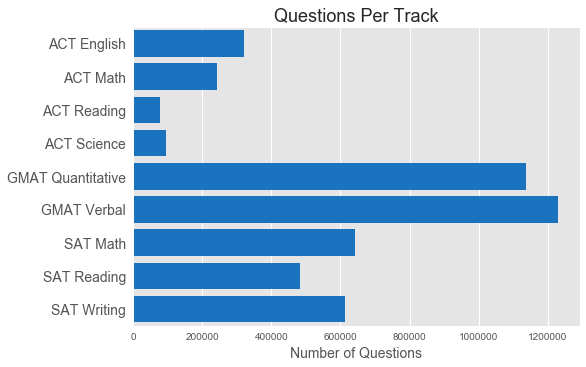

In [70]:
# Create bar plot for track_name distribution:
sns.countplot(data=df, y='track_name', color='#0074d9')

# Create bar labels:
tracks = ('ACT English', 'ACT Math', 'ACT Reading', 'ACT Science', 'GMAT Quantitative', 
              'GMAT Verbal', 'SAT Math', 'SAT Reading', 'SAT Writing')
plt.yticks(np.arange(len(tracks)), tracks, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions Per Track', fontsize=18)

# Display the plot:
plt.show()

<a id='subtrack_name' href='#top'>back to menu</a>

#### subtrack_name
---

1. How many subtracks?
2. How many questions per subtrack?
3. What are the statistics related to outcome?

In [71]:
# Print the number of unique subtrack_name values:
print(('Number of Subtracks:'), (len( df.subtrack_name.unique() )))

Number of Subtracks: 16


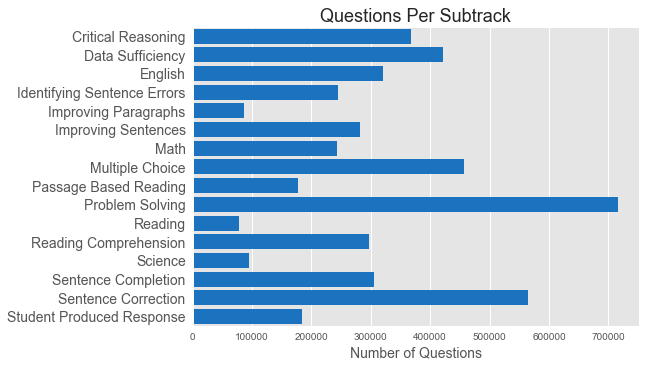

In [72]:
# Create bar plot for subtrack_name distribution:
sns.countplot(data=df, y='subtrack_name', color='#0074d9')

# Create bar labels:
subtracks = ('Critical Reasoning', 'Data Sufficiency', 'English', 'Identifying Sentence Errors', 
             'Improving Paragraphs', 'Improving Sentences', 'Math', 'Multiple Choice', 
             'Passage Based Reading', 'Problem Solving', 'Reading', 'Reading Comprehension', 
             'Science', 'Sentence Completion', 'Sentence Correction', 'Student Produced Response')
plt.yticks(np.arange(len(subtracks)), subtracks, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions Per Subtrack', fontsize=18)

# Display the plot:
plt.show()

<a id='tag_string' href='#top'>back to menu</a>

#### tag_string
---

<a id='question_type' href='#top'>back to menu</a>

#### question_type
---

1. How many question types?
2. How many questions per question type?
3. What are the statistics related to outcome?

In [73]:
# Print the number of unique question_type values:
print(('Number of Question Types:'), (len( df.question_type.unique() )))

Number of Question Types: 2


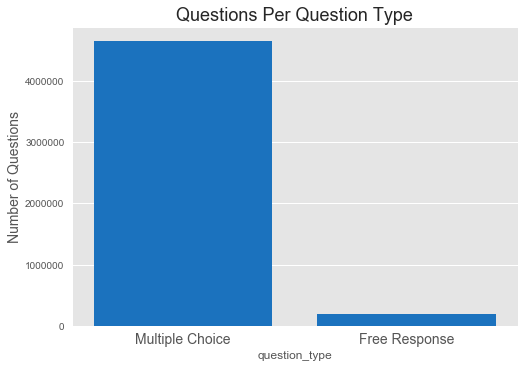

In [74]:
# Create bar plot for outcome distribution:
sns.countplot(data=df, x='question_type', color='#0074d9');

# Create bar labels:
plt.xticks(np.arange(2), ('Multiple Choice', 'Free Response'), fontsize=14)

# Create axis labels and the title:
plt.xlabel('question_type')
plt.ylabel('Number of Questions', fontsize=14)
plt.title('Questions Per Question Type', fontsize=18)

# Display the plot:
plt.show()

### User-Driven Features

<a id='game_type' href='#top'>back to menu</a>

#### game_type
---

**`BookmarkGame: 0`** - values are like `ReviewGames`, but on specific questions the user has bookmarked.

**`ChallengeGame: 1`** - values are solo games where the user is taking a series of questions intended to challenge them and give them the best opportunities for learning.

**`CompetitiveGame: 2`** - values are the most different from other types of games. In these, once one user has answered correctly, the other users should be marked as 'skipped', and the game immediately proceeds to the next question. At the end of the game, whomever has answered the most questions correct wins.

**`ComputerAdaptiveTestGame: 3`** - values are the user answering questions on a full-length CAT, designed to mimic the algorithms used in the actual test, to ask them questions designed to maximize the information gain on the user's ability. TRYING TO IMPROVE THIS.

**`CustomGame: 4`** - values are normal games (like `PracticeGame`), but with some settings (such as specific areas or difficulty levels) chosen by the user.

**`DiagnosticGame: 5`** - values are solo games which are intended to give an initial rough assessment of the user's ability level.

**`NULL: 6`** - values represent a data collection failure.

**`PracticeGame: 7`** - is the main type of game: in these, everyone in the game is seeing the same question at the same time; once everyone has answered, the answer is displayed; once everyone is ready to continue, the round advances to a new question.  Note that these can be solo games as well.

**`RecitationGame: 8`** - represents a game led by a tutor through a series of questions, with the tutor controlling the pace of advancement.

**`ReviewGame: 9`** - is a solo game (essentially a solo `PracticeGame`) started by a user to review questions they have played in the past.

**`StudyHallGame: 10`** - is the newest type of game: in these, users are answering their own series of questions as though they were in a solo practice game, but there is a single "study hall" chat where people can ask for help on questions.

**`StudyTaskGame: 11`** - is a game where the user is answering questions in a common skill area, in order to achieve a task in their personalized study plan.

1. How many game types? 
2. How many questions per game type?
3. What are the statistics related to outcome?

In [75]:
# NULL game_type observations were eliminated earlier, 
# so confirm that there are 11 of game_type - 

# Print the number of unique game_type values:
print(('Number of Game Types:'), (len( df.game_type.unique() )))

Number of Game Types: 11


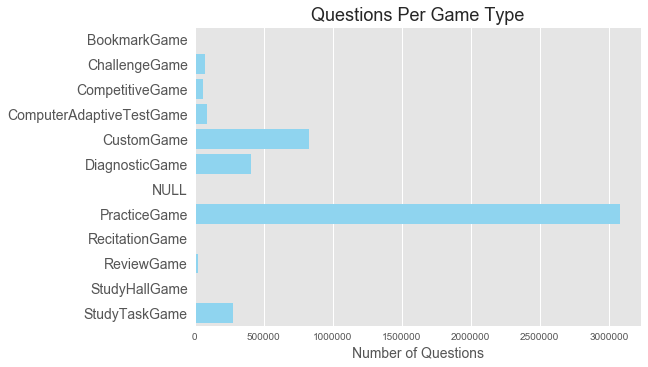

In [76]:
# Create bar plot for game_type distribution:
sns.countplot(data=df, y='game_type', color='#7fdbff')

# Create bar labels:
game_types = ('BookmarkGame', 'ChallengeGame', 'CompetitiveGame', 'ComputerAdaptiveTestGame', 
              'CustomGame', 'DiagnosticGame', 'NULL', 'PracticeGame', 'RecitationGame', 
              'ReviewGame', 'StudyHallGame', 'StudyTaskGame')
plt.yticks(np.arange(len(game_types)), game_types, fontsize=14)

# Create axis labels and the title:
plt.xlabel('Number of Questions', fontsize=14)
plt.ylabel('')
plt.title('Questions Per Game Type', fontsize=18)

# Display the plot:
plt.show()

In [77]:
df.game_type.value_counts()

7     3080719
4      829697
5      406253
11     274122
3       91485
1       72327
2       57851
9       21362
0        3989
10       2620
8        1924
6           0
Name: game_type, dtype: int64

<a id='num_players' href='#top'>back to menu</a>

#### num_players
---



In [78]:
# Print the number of unique num_players values:
print(('Unique Values for Number of Players:'), (len( df.num_players.unique() )))

Unique Values for Number of Players: 34


In [79]:
df.num_players.value_counts() 

1     3244048
2      687139
3      402027
4      247331
5      181050
6       49321
7       16078
8        6841
9        3348
10       1862
11        866
12        542
13        465
15        288
14        277
19        129
16        103
21         94
20         94
18         87
23         81
22         56
17         46
27         37
31         27
24         26
30         24
33         21
45         18
25          8
32          7
29          5
51          2
78          1
Name: num_players, dtype: int64

<a id='summary' href='#top'>back to menu</a>

## Summarize and Save

In [80]:
# Index the dataset by users, then start time; sort and save:
# df = df.set_index(['user_id', 'round_started_at']).sort_index()

In [81]:
# Inspect one more time:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4842349 entries, 0 to 4851474
Data columns (total 15 columns):
user_id             int64
round_started_at    datetime64[ns]
answered_at         datetime64[ns]
deactivated_at      datetime64[ns]
round_ended_at      datetime64[ns]
round_duration      timedelta64[ns]
outcome             int64
group_name          category
track_name          category
subtrack_name       category
tag_ids             object
question_id         category
question_type       category
game_type           category
num_players         category
dtypes: category(7), datetime64[ns](4), int64(2), object(1), timedelta64[ns](1)
memory usage: 529.6+ MB


In [82]:
# Inspect one more time:
df.head()

,user_id,round_started_at,answered_at,deactivated_at,round_ended_at,round_duration,outcome,group_name,track_name,subtrack_name,tag_ids,question_id,question_type,game_type,num_players
0,85818,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,2010-08-18 20:18:18,00:01:05,0,1,5,14,"[222, 233, 240, 246]",5560,0,7,1
1,85818,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,2010-08-18 20:20:34,00:01:22,1,1,5,0,"[24, 49]",4681,0,7,1
2,85818,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,2010-08-18 20:21:56,00:01:14,1,1,5,0,"[31, 49]",1529,0,7,1
3,85818,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,2010-08-18 20:23:05,00:01:02,1,1,5,0,"[31, 49]",2908,0,7,1
4,85818,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,2010-08-18 20:26:08,00:02:57,1,1,5,11,"[183, 194, 207]",1773,0,7,1


### Training Dataset (Before & After Cleaning)


TOTAL OBSERVATIONS
* Before:  4,851,475
* After:  4,842,349


TOTAL VARIABLES
* Before:  17 
* After:  15
 
 
NUMBER OF USERS
* Before: 179,106
* After: 178,982
 
 
UNIQUE QUESTIONS
* Before:  6,045 
* After:  6,045


### Data Wrangling Process
1. Import Packages, Dataset & Inspect Raw Data
3. Re-Organize Columns & Time Data Computation
5. Evaluate & Resolve Missing Data
6. Evaluate & Resolve Duplicate Data


### Feature Summary
|Feature ID|Description|Feature Type|Total Unique|Distribution of Questions|Mean|Median|Std|
|:---------|:----------|:-----------|-----------:|:-----------------------:|---:|-----:|--:|
|**user_id**|Unique identifier for each user.|Categorical|179,032|Input [[51]](#user_id)|--|--|--|
|**round_duration**|Total time question is viewed by the user.|Numerical|--|--|00:01:05|00:00:51|00:00:54
|**group_name**|Test for which the user is preparing.|Categorical|3|Input [[68]](#group_name)|--|--|--|
|**track_name**|Concentration within each test.|Categorical|9|Input [[70]](#track_name)|--|--|--| 
|**subtrack_name**|Sub-classification of each track.|Categorical|16|Input [[72]](#subtrack_name)|--|--|--|
|**tag_ids**|A list of tags identifying additional characteristics of each question.|Categorical|--|--|--|--|--|
|**question_id**|Identifier for each unique question.|Categorical|6,045|Input [[66]](#question_id)|--|--|--|
|**question_type**|Multiple choice or free response.|Categorical|2|Input [[74]](#question_type)|--|--|--|
|**game_type**|User choice of the exercise format.|Categorical|12|Input [[76]](#game_type)|--|--|--|
|**num_players**|Total number of users in the game at the time.|Categorical|33|Input [[--]](#num_players)|--|--|--|
|correct_ratio|User ratio of correct answers.|Numerical|--|Input [[55]](#user_id)|0.35|0.36|0.31|


### Results of Initial Exploration

#### Users
* Outcome Statistics?
* Best/worst performing users?
* Time spent answering questions?

#### Questions
* Outcome Statistics?
* Best/worst performing questions?
* Which have the best/worst times?


In [83]:
# Save the clean dataframe to the interim data directory:
# df.to_csv('../data/interim/training_clean.csv')